In [1]:
import numpy as np
from scipy import linalg, special
import seaborn as sns
import pandas as pd
import os
from inspect import getmembers
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import dill
from equilibrator_api import ComponentContribution, Q_, Reaction
import requests
import xmltodict
import pint
import cvxpy as cp
import itertools
import copy

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

A + B -E1> C -E2> D

B -E3> F

A -E4> G

# Testing eQuilibrator

In [2]:
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")



In [3]:
from equilibrator_api import Reaction
compound_ids = ["WATER", "ADP", "ATP", "Pi"]
compound_dict = {cid : cc.get_compound(f"metacyc.compound:{cid}") for cid in compound_ids}
atpase_reaction = Reaction({
    compound_dict["ATP"]: -1,
    compound_dict["WATER"]: -1,
    compound_dict["ADP"]: 1,
    compound_dict["Pi"]: 1,
})

In [4]:
standard_dg_prime = cc.standard_dg_prime(atpase_reaction)
standard_dg_prime

<Measurement(-29.144472212600157, 0.3042778553577678, kilojoule / mole)>

In [5]:
cytoplasmic_p_h = Q_(7.5)
cytoplasmic_ionic_strength = Q_("250 mM")
periplasmic_p_h = Q_(7.0)
periplasmic_ionic_strength = Q_("200 mM")
e_potential_difference = Q_("0.15 V")
cytoplasmic_reaction = "bigg.metabolite:pep = bigg.metabolite:g6p + bigg.metabolite:pyr"
periplasmic_reaction = "bigg.metabolite:glc__D = "

cc = ComponentContribution()
cc.p_h = cytoplasmic_p_h
cc.ionic_strength = cytoplasmic_ionic_strength
standard_dg_prime = cc.multicompartmental_standard_dg_prime(
    cc.parse_reaction_formula(cytoplasmic_reaction),
    cc.parse_reaction_formula(periplasmic_reaction),
    e_potential_difference=e_potential_difference,
    p_h_outer=periplasmic_p_h,
    ionic_strength_outer=periplasmic_ionic_strength,
)

print(standard_dg_prime)


(-44.8 +/- 0.6) kilojoule / mole


In [6]:
cc.get_compound_by_inchi("WQZGKKKJIJFFOK-GASJEMHNSA-N")

# Using eQuilibrator to generate equilibrium constants

In [135]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})
# Issue web service request:
r = s.get('https://websvc.biocyc.org/getxml?id=ECOLI:6PFRUCTPHOS-RXN&detail=low&fmt=json')

In [191]:
name = 'F16ALDOLASE-RXN'

r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
o = xmltodict.parse(r.content)['ptools-xml']
o['Reaction']['enzymatic-reaction']['Enzymatic-Reaction'][0]['@frameid']

'F16ALDOLASE-ENZRXN-CLASSI'

In [211]:

rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']

rxns_dict = {}
stoich_dict = {}
regulation_dict = {}

for name in rxns_names:
    r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
    rxn = xmltodict.parse(r.content)['ptools-xml']

    rxn_dict = {}
    stoich_loop_dict = {}
    regulation_loop_dict = {}
    left = rxn['Reaction']['left']
    right = rxn['Reaction']['right'] 
    
    # i will know exact complex in model (connected to rxn), but for now will pick random
    enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
    
    if type(left) is dict:
        left = [left]
    
    if type(right) is dict:
        right = [right]
        
    if type(enz_rxn) is dict:
        enz_rxn = [enz_rxn]
    
    enz_rxn_id =  enz_rxn[0]['@frameid']
    re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
    oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']['regulated-by']['Regulation']
    
    if type(oe) is dict:
        oe = [oe]
        
    # add regulators, target regulator directly with id to get info like irreversible, etc
    for regulator in oe:
        reg_name = regulator['regulator']['Compound']['@frameid']
        reg_type = regulator['mode']['#text']
        reg_type = 1 if reg_type == '+' else -1
        regulation_loop_dict[reg_name] = reg_type
    
    for mol in left:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] = -1
            stoich_loop_dict[cid] = -1

    for mol in right:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] =  1
            stoich_loop_dict[cid] = 1
    
    rxns_dict[name] = Reaction(rxn_dict)
    stoich_dict[name] = stoich_loop_dict
    regulation_dict[name] = regulation_loop_dict
    
rxns_dict

{'6PFRUCTPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x169e57130>,
 'F16ALDOLASE-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1765fa190>,
 '2TRANSKETO-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1756aba90>,
 'TRIOSEPISOMERIZATION-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x173909070>}

In [113]:
(standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")

In [114]:
standard_dg_prime

Magnitude,[-21.05010908198642 22.047924530096907 -5.946115510564027 -5.617742386692498]
Units,kilojoule/mole


In [115]:
dg_uncertainty

Magnitude,[[1.5398212990074922 -2.2167471180569773 0.6541085596545129 -0.004664260811860303] [-2.2167471180569773 5.286946034707553 -2.4322877177623594 -0.1291182736017488] [0.6541085596545129 -2.4322877177623594 5.547270812427002 -0.08893998540652082] [-0.004664260811860303 -0.1291182736017488 -0.08893998540652082 0.3010346102557717]]
Units,kilojoule2/mole2


In [116]:
R = 0.008314 # kJ/mol*K
T = 298.15 # K

In [117]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

array([4.87556287e+03, 1.37137368e-04, 1.10096201e+01, 9.64363243e+00])

# Calculating set of kinetic parameters with given equilibrium constants and arbitrary fluxes

In [118]:
Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_met = len(Sd.index)
n_rxn = len(Sd.columns)

Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


In [119]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

K_eq = np.log(keq)
vE = np.array([100, 20, -30, -10])

K_eq[vE < 0] = 1/K_eq[vE < 0] 

lvE = np.log(np.abs(vE))

pd.DataFrame(np.array([K_eq, vE]), columns=Sd.columns, index=["$K_{eq}$", "$v$"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,0.41688,0.441248
$v$,100.000000,20.000000,-30.00000,-10.000000


In [100]:
# set up variables

S = np.array(Sd)
S = np.multiply(S, vE/np.abs(vE)).astype(np.int8)
S[S == -0] = 0
S_s = -np.copy(S)
S_p = np.copy(S) #reverse neg sign
S_s[S > 0] = 0
S_p[S < 0] = 0

S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())

# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p

# index 
met_s_nz

array([0, 0, 1, 4, 5, 6])

In [101]:
# number of saturation terms for sub, prod
n_alpha = np.sum(np.power(2, S_s.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p.sum(axis=0)) - 1)

# saturation matrix setup
C_alpha = np.zeros([n_alpha, len(met_s_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz)])

# to separate different reactions saturation terms. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    idx_cur_rxn = rxn_s_nz == i
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = rxn_p_nz == i
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [102]:
C_alpha

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.]])

In [103]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_s)[d_alpha == i] - cp.multiply(np.ones(n_term_s), -S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                 lvE[i] + (C_beta @ y_p)[d_beta == i] - cp.multiply(np.ones(n_term_p), -S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                 lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                 cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                             )
                   )  # remove +1 here, could also have cfwd outside objec. 
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [104]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [107]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  - (lvE[i])  >= 0)  # add minus since s matrix has minus

In [108]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12, cfwd[0] == 7,
          ]

constr.extend(haldane)
constr.extend(fwd_flux)
constr.extend([S.T @ c <= K_eq])

In [109]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 10 01:21:18 PM: Your problem has 31 variables, 12 constraints, and 0 parameters.
(CVXPY) Mar 10 01:21:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 10 01:21:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 10 01:21:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 10 01:21:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) Mar 10 01:21:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

0.0006036873328945923

# Checking correctness of result

In [120]:
cfwd.value

array([7.        , 3.06552725, 5.43321196, 3.17602329])

In [121]:
crev.value

array([4.31072640e-07, 5.81697598e+00, 3.78172989e+00, 2.73467764e+00])

In [34]:
c.value

array([ 6.44993211e+00,  1.20766902e+00, -1.85408944e-05, -1.85408944e-05,
        1.00288779e+01, -9.66438518e-06, -1.86137921e+00, -1.13584985e-06,
       -1.13584985e-06])

In [35]:
Km_s.value

array([-2.13406131e-04,  1.23318342e+00, -4.69337272e-04,  4.93079985e+00,
       -1.69665754e-06, -4.63116450e-05])

In [36]:
Km_p.value

array([ 1.68559254e-05,  1.68559254e-05,  1.49127481e+00, -7.62551598e-04,
       -1.21151632e+00, -9.90749863e-05, -7.32268863e-04, -7.32268863e-04])

## Checking Haldane and fwd/rev flux ratios are satisfied

In [37]:
for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    print("haldane", cfwd.value[i] - crev.value[i] + r[S_p_idx] @ Km_p.value[Km_p_idx] - (-r[S_s_idx]) @ Km_s.value[Km_s_idx] - K_eq[i] )
    # print(cfwd.value[i], (-r[S_s_idx]), y_s.value[Km_s_idx], crev.value[i], r[S_p_idx],  y_p.value[Km_p_idx])
    print("forward", cfwd.value[i] + (-r[S_s_idx]) @ y_s.value[Km_s_idx] - (crev.value[i] + r[S_p_idx] @ y_p.value[Km_p_idx]))

haldane -2.998881143412291e-10
forward 6.120751148320714
haldane 3.141007454132705e-10
forward 2.9957393186803047
haldane -1.4722500996100507e-11
forward 5.005435585727745
haldane -1.5581591572555453e-11
forward 2.3026178110690045


In [38]:
y_s.value

array([ 6.45014551e+00,  5.21674868e+00,  1.20813836e+00,  5.09807804e+00,
       -7.96772764e-06, -1.86133290e+00])

In [39]:
y_p.value

array([-3.53968198e-05, -3.53968198e-05,  8.53760309e+00,  7.52887212e-04,
       -6.49862892e-01, -1.86128013e+00,  7.31133013e-04,  7.31133013e-04])

## Checking that objective has been minimized.

Need to rearrange terms.

In [40]:
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    
    LSE_expr.append(           [ (C_alpha @ y_s.value)[d_alpha == i] - np.multiply(np.ones(n_term_s), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx]) - cfwd.value[i],  
                                 (C_beta @ y_p.value)[d_beta == i] - np.multiply(np.ones(n_term_p), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx]) - cfwd.value[i],
                                 0 - np.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx])  - cfwd.value[i],
                                 np.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p.value[Km_p_idx])  + crev.value[i]
                                 - np.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s.value[Km_s_idx])  - cfwd.value[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    

est = np.zeros(4)    

for i, rxn in enumerate(LSE_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    est[i] = np.log(s)
    

# est is obj. 
print(np.array([np.exp(-est),np.exp(lvE)]))

[[ 82.1570784   10.2567969   25.12093559   5.2634056 ]
 [100.          20.          30.          10.        ]]


## How closely does the objective match our target kcats?

In [41]:
print(np.array([np.exp(-est),np.exp(lvE)]))

[[ 82.1570784   10.2567969   25.12093559   5.2634056 ]
 [100.          20.          30.          10.        ]]


Remarkable. 

# What do fluxes with reverse flow look like?

In [42]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_s.value)[d_alpha == i] ,  
                                 (C_beta @ y_p.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [43]:
fwd_sat/sat

array([0.09141673, 0.9817371 , 0.13197119, 0.46393321])

In [44]:
back_sat/sat

array([0.22023099, 0.00313345, 0.00461185, 0.07212988])

In [45]:
np.exp(cfwd.value) * fwd_sat/sat 

array([100.25062112,  21.05410455,  30.20599317,  11.11181114])

In [46]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.03039003,  20.00140674,  30.00357008,  10.00066638])

In [47]:
np.exp(crev.value) * back_sat/sat

array([0.22023109, 1.05269781, 0.2024231 , 1.11114476])

In [48]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

Substrate Km: ['1.000', '3.432', '1.000', '138.490', '1.000', '1.000']
Product Km: ['1.000', '1.000', '4.443', '0.999', '0.298', '1.000', '0.999', '0.999']
Fwd kcat: ['1096.633', '21.446', '228.883', '23.951']
Rev kcat: ['1.000', '335.955', '43.892', '15.405']
Concentrations: ['632.659', '3.346', '1.000', '1.000', '22671.817', '1.000', '0.155', '1.000', '1.000']


In [65]:
reconst_df = pd.DataFrame({"Reaction": Sd.columns, "True fluxes": np.abs(vE), "Estimated fluxes": np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat})
reconst_df = reconst_df.melt(id_vars="Reaction")
reconst_df

,Reaction,variable,value
0,6PFRUCTPHOS-RXN,True fluxes,100.000000
1,F16ALDOLASE-RXN,True fluxes,20.000000
2,2TRANSKETO-RXN,True fluxes,30.000000
3,TRIOSEPISOMERIZATION-RXN,True fluxes,10.000000
4,6PFRUCTPHOS-RXN,Estimated fluxes,100.030390
5,F16ALDOLASE-RXN,Estimated fluxes,20.001407
6,2TRANSKETO-RXN,Estimated fluxes,30.003570
7,TRIOSEPISOMERIZATION-RXN,Estimated fluxes,10.000666


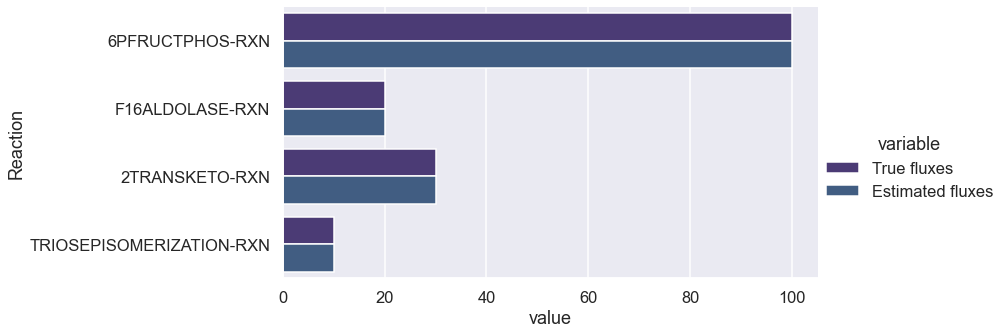

In [71]:
sns.catplot(y="Reaction", hue="variable", x="value", data=reconst_df, kind="bar", aspect=2.5)
plt.savefig("notebooks/fbagd/figures/reconstruction.png", dpi=300)

In [53]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.03039003,  20.00140674,  30.00357008,  10.00066638])

# Including inhibition

## I'm excluding some of the first operations as they are the same. 

In [279]:
Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


Adding regulation dict.

In [280]:
Sr_min = pd.DataFrame(regulation_dict).fillna(0).astype(np.int8)

Sr = Sd.copy()
Sr.loc[:,:] = 0
Sr.loc[Sd.index.intersection(Sr_min.index), :] = Sr_min.loc[Sd.index.intersection(Sr_min.index), :]
Sr

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,1,0,0,0
ATP,0,0,0,0
PROTON,0,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,0,0,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,0,0,0
GAP,0,0,0,0
ERYTHROSE-4P,0,0,0,0
XYLULOSE-5-PHOSPHATE,0,0,0,0


In [281]:
pd.DataFrame(np.array([K_eq, vE]), columns=Sd.columns, index=["$K_{eq}$", "$v$"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,0.41688,0.441248
$v$,100.000000,20.000000,-30.00000,-10.000000


In [282]:
# set up variables

S = np.array(Sd)
S = np.multiply(S, vE/np.abs(vE)).astype(np.int8)
S[S == -0] = 0
S_s = -np.copy(S)
S_p = np.copy(S) #reverse neg sign
S_s[S > 0] = 0
S_p[S < 0] = 0
S_i = np.copy(np.array(Sr) == -1)
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())

# TODO Refactor all the below lines as one liners 
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) 
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition. 
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p
y_i = c[met_i_nz] - Km_i if n_Km_i else None
y_a = -(c[met_a_nz] - Km_a) if n_Km_a else None

# saturation stacks
if n_Km_i and n_Km_a:
    y_f = cp.hstack((y_s, y_i, y_a))
    y_r = cp.hstack((y_p, y_i, y_a))
elif n_Km_i:
    y_f = cp.hstack((y_s, y_i))
    y_r = cp.hstack((y_p, y_i))
elif n_Km_a:
    y_f = cp.hstack((y_s, y_a))
    y_r = cp.hstack((y_p, y_a))
else:
    y_f = y_s
    y_r = y_p

In [283]:
rxn_a_nz

array([0, 0])

In [284]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, S_s_comb.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p_comb.sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act. 
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [285]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_f)[d_alpha == i] - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                 lvE[i] + (C_beta @ y_r)[d_beta == i] - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                 lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                 cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                             )
                   )  # remove +1 here, could also have cfwd outside objec. 
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [298]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [299]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  - (lvE[i])  >= 0)  # add minus since s matrix has minus

In [302]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12, cfwd[0] == 7,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])

constr.extend(haldane)
constr.extend(fwd_flux)
constr.extend([S.T @ c <= K_eq])

In [303]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 13 06:10:05 PM: Your problem has 33 variables, 14 constraints, and 0 parameters.
(CVXPY) Mar 13 06:10:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 06:10:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 06:10:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 06:10:05 PM: Compiling problem (target solver=ECOS).
(CVXPY) Mar 13 06:10:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

0.0006041709038005074

In [304]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['1.000', '4.042', '1.000', '143.517', '1.000', '1.000']
Product Km: ['1.000', '1.000', '4.444', '1.000', '0.301', '1.000', '1.000', '1.000']
Fwd kcat: ['1096.633', '21.458', '228.591', '23.950']
Rev kcat: ['1.000', '327.751', '37.248', '15.405']
Concentrations: ['751.043', '2.886', '1.000', '1.000', '22672.332', '1.000', '0.155', '1.000', '1.000']
Activation Km: ['5.975', '0.008']


# Check flux reconstruction with inhibition/activation

In [305]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_f.value)[d_alpha == i] ,  
                                 (C_beta @ y_r.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [306]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.04995945,  20.00088252,  30.00181073,  10.00034055])

In [315]:
Km_a.value

array([ 1.78752284, -4.79197675])

Both enzymes have a much higher concentration than K_a, e.g. both are activated.

In [316]:
np.exp(-y_a.value)

array([125.70522754, 120.53831122])

About 99%.

# Reworking directionality to just rearrange terms, so we can add multiple substrate sets. 

In [ ]:
vE

array([100,  20, -30, -10])

In [281]:
K_eq = np.log(keq)
vE = np.array([100, 20, -30, -10])

K_eq[vE < 0] = 1/K_eq[vE < 0] 

lvE = np.log(np.abs(vE))
pd.DataFrame(np.array([K_eq, vE]), columns=Sd.columns, index=["$K_{eq}$", "$v$"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,0.41688,0.441248
$v$,100.000000,20.000000,-30.00000,-10.000000


In [282]:
# set up variables

S = np.array(Sd)
S = np.multiply(S, vE/np.abs(vE)).astype(np.int8)
S[S == -0] = 0
S_s = -np.copy(S)
S_p = np.copy(S) #reverse neg sign
S_s[S > 0] = 0
S_p[S < 0] = 0
S_i = np.copy(np.array(Sr) == -1)
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())

# TODO Refactor all the below lines as one liners 
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices. 
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well. 
rxn_s_nz = S_s_nz[1, :]   
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape) 
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape) 
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable(n_met)
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition. 
y_s = c[met_s_nz] - Km_s
y_p = c[met_p_nz] - Km_p
y_i = c[met_i_nz] - Km_i if n_Km_i else None
y_a = -(c[met_a_nz] - Km_a) if n_Km_a else None

# saturation stacks
if n_Km_i and n_Km_a:
    y_f = cp.hstack((y_s, y_i, y_a))
    y_r = cp.hstack((y_p, y_i, y_a))
elif n_Km_i:
    y_f = cp.hstack((y_s, y_i))
    y_r = cp.hstack((y_p, y_i))
elif n_Km_a:
    y_f = cp.hstack((y_s, y_a))
    y_r = cp.hstack((y_p, y_a))
else:
    y_f = y_s
    y_r = y_p

In [283]:
rxn_a_nz

array([0, 0])

In [284]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, S_s_comb.sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, S_p_comb.sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act. 
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations. 
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):
    
    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i
        
    idx += r # add row # 

idx = 0
    
for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))
    
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]
    
    r, _ = sat_perm.shape
    
    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i
        
    idx += r # add row # 

In [285]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    LSE_expr.append(cp.hstack( [ lvE[i] + (C_alpha @ y_f)[d_alpha == i] - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],  
                                 lvE[i] + (C_beta @ y_r)[d_beta == i] - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ y_s[Km_s_idx]) - cfwd[i],
                                 lvE[i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i],
                                 cp.multiply(np.ones(1), S.T[i, S_p_idx] @ y_p[Km_p_idx])  + crev[i]
                                 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ y_s[Km_s_idx])  - cfwd[i]
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                             )
                   )  # remove +1 here, could also have cfwd outside objec. 
    
#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [298]:
l = 0.0000001
e = 0.00001
f = 0.0000001
reg =  cp.sum(cp.hstack([cfwd, crev, c])) + cp.sum(cp.hstack([-Km_s, -Km_p]))# regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, c])) + cp.norm1(cp.hstack([-Km_s, -Km_p]))# regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1))

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(n_rxn):
    loss += cp.norm2(cp.pos(cp.log_sum_exp(LSE_expr[i])))
loss += l * reg 
loss += e * reg2
loss += f * reg3
# 

In [299]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])  # add minus since s matrix has minus
    fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ y_s[Km_s_idx] - (crev[i] + r[S_p_idx] @ y_p[Km_p_idx])  - (lvE[i])  >= 0)  # add minus since s matrix has minus

In [302]:
constr = [cp.hstack([cfwd, crev, c, Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, c, Km_s, Km_p]) <= 12, cfwd[0] == 7,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])

constr.extend(haldane)
constr.extend(fwd_flux)
constr.extend([S.T @ c <= K_eq])

In [303]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 13 06:10:05 PM: Your problem has 33 variables, 14 constraints, and 0 parameters.
(CVXPY) Mar 13 06:10:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 06:10:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 06:10:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 06:10:05 PM: Compiling problem (target solver=ECOS).
(CVXPY) Mar 13 06:10:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

0.0006041709038005074

In [304]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])
print('Concentrations:', [f'{val:.3f}' for val in np.exp(c.value)])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['1.000', '4.042', '1.000', '143.517', '1.000', '1.000']
Product Km: ['1.000', '1.000', '4.444', '1.000', '0.301', '1.000', '1.000', '1.000']
Fwd kcat: ['1096.633', '21.458', '228.591', '23.950']
Rev kcat: ['1.000', '327.751', '37.248', '15.405']
Concentrations: ['751.043', '2.886', '1.000', '1.000', '22672.332', '1.000', '0.155', '1.000', '1.000']
Activation Km: ['5.975', '0.008']


# Check flux reconstruction with inhibition/activation

In [305]:
sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    n_term_s = np.sum(d_alpha == i) 
    n_term_p = np.sum(d_beta == i)
    n_term = n_term_s + n_term_p
    
    
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries
    
    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]
    
    sat_expr.append(           [ (C_alpha @ y_f.value)[d_alpha == i] ,  
                                 (C_beta @ y_r.value)[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1) 
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[Km_p_idx])) # + cfwd.value[i]
    
    

for i, rxn in enumerate(sat_expr):
    s = 0
    
    for term in rxn:
        s += np.sum(np.exp(term))
        
    sat[i] = (s)

In [306]:
np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

array([100.04995945,  20.00088252,  30.00181073,  10.00034055])

In [315]:
Km_a.value

array([ 1.78752284, -4.79197675])

Both enzymes have a much higher concentration than K_a, e.g. both are activated.

In [316]:
np.exp(-y_a.value)

array([125.70522754, 120.53831122])

# Bigger network

In [49]:
rxns_names = ['PGLUCISOM-RXN', '6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', 
              '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN', 'GAPOXNPHOSPHN-RXN', 'PHOSGLYPHOS-RXN', '3PGAREARR-RXN',
             '2PGADEHYDRAT-RXN', 'PEPDEPHOS-RXN']


In [50]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})
# Issue web service request:
r = s.get('https://websvc.biocyc.org/getxml?id=ECOLI:6PFRUCTPHOS-RXN&detail=low&fmt=json')

In [51]:
rxns_dict = {}
stoich_dict = {}

for name in rxns_names:
    r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
    rxn = xmltodict.parse(r.content)

    rxn_dict = {}
    stoich_loop_dict = {}
    left = rxn['ptools-xml']['Reaction']['left']
    right = rxn['ptools-xml']['Reaction']['right']
    
    if type(left) is dict:
        left = [left]
    
    if type(right) is dict:
        right = [right]
    
    for mol in left:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] = -1
            stoich_loop_dict[cid] = -1

    for mol in right:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] =  1
            stoich_loop_dict[cid] = 1
    
    rxns_dict[name] = Reaction(rxn_dict)
    stoich_dict[name] = stoich_loop_dict
    
rxns_dict

{'PGLUCISOM-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x17484fee0>,
 '6PFRUCTPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x17623deb0>,
 'F16ALDOLASE-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x169e54550>,
 '2TRANSKETO-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x169e54610>,
 'TRIOSEPISOMERIZATION-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x174680bb0>,
 'GAPOXNPHOSPHN-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x169e57e80>,
 'PHOSGLYPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x174680df0>,
 '3PGAREARR-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x28039fc70>,
 '2PGADEHYDRAT-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x28039ff10>,
 'PEPDEPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x28039ff70>}

In [52]:
(standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")
R = 0.008314 # kJ/mol*K
T = 298.15 # K

dG = standard_dg_prime._magnitude
keq = np.exp(-dG/(R*T))
keq

array([1.59075969e+00, 4.87556287e+03, 1.37137368e-04, 1.10096201e+01,
       9.64363243e+00, 6.25653428e-01, 3.75692596e-04, 6.08165392e+00,
       4.65230074e+00, 4.12248676e-05])